In [1]:
# import dependencies
import pybamm
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize

# Sensitivities and data fitting using PyBaMM

In the previous notebook, we used a `pybamm.InputParameter` to enable us to run many simulations with varying parameters. Here we will demonstrate PyBaMM's ability to calculate the senstivities of model outputs with respect to input parameters. To be more specific, given a model output $f(t, a)$, where $a$ is an input parameter, we wish to calculate $\frac{\partial f}{\partial a}(t, a)$.

First we will demonstrate using a toy model, given by the equations

$$\frac{dy}{dt} = a y$$

with a scalar state variable $y$ and a scalar parameter $a$, and initial conditions

$$y(0) = 1$$

We will also define a model output given by $f = y^2$

In [3]:
# setup a simple test model
model = pybamm.BaseModel('name')
y = pybamm.Variable("y")
a = pybamm.InputParameter("a")
model.rhs = {y: a * y}
model.initial_conditions = {y: 1}
model.variables = {"y squared": y ** 2}

solver = pybamm.CasadiSolver(
    mode="fast", rtol=1e-10, atol=1e-10
)
t_eval = np.linspace(0, 1, 80)


We can solve the model using a specific value of $a = 1$ as before. However, now we will also calculate the forward sensitivities of the model by setting the argument `calculate_sensitivies=True`. Note that this argument will also accept a list of input parameters to calculate the sensitivities for, but setting it to `True` will calculate the sensitivities for **all** input parameters of the model 

In [4]:
solution = solver.solve(
    model, t_eval, inputs={'a': 1},
    calculate_sensitivities=True
)

We can now access the solution as normal, and the sensitivities using the syntax: `solution[output_name].sensitivities[input_parameter_name]`

Note that a current restriction to the sensitivity calculation is that it will only return the sensitivities at the values of `t_eval` used to solve the model. Any interpolation between these values will have to be done manually

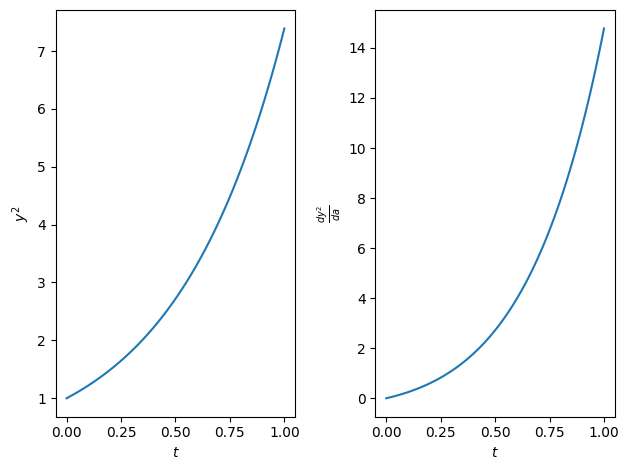

In [5]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(t_eval, solution["y squared"](t_eval))
axs[0].set_ylabel(r'$y^2$')
axs[0].set_xlabel(r'$t$')
axs[1].plot(solution.t, solution["y squared"].sensitivities["a"])
axs[1].set_ylabel(r'$\frac{dy^2}{da}$')
axs[1].set_xlabel(r'$t$')
plt.tight_layout()
plt.show()

## Sensitivities for the DFN model

We can do the same for the DFN model included in PyBaMM. Once again we will setup the DFN model using "Current function" as an input parameter. This is the parameter we wish to calculate the sensitivities with respect to.

In [5]:
# now lets do the same for the DFN model

# load model
model = pybamm.lithium_ion.DFN()
# create geometry
geometry = model.default_geometry

# load parameter values and process model and geometry
param = model.default_parameter_values

# we want to calculate the sensitivities of the "Current function" parameter, so set
# this an an input parameter
param.update({"Current function [A]": "[input]"})

param.process_geometry(geometry)
param.process_model(model)

# set mesh
var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 30, var.x_s: 30, var.x_p: 30, var.r_n: 10, var.r_p: 10}
mesh = pybamm.Mesh(geometry, model.default_submesh_types, var_pts)

# discretise model
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# create solver
t_eval = np.linspace(0, 3600, 100)
solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-3)

We can now evaluate the senstivities of, for example, the "Terminal voltage" output of the model with respect to the input parameter "Current function".

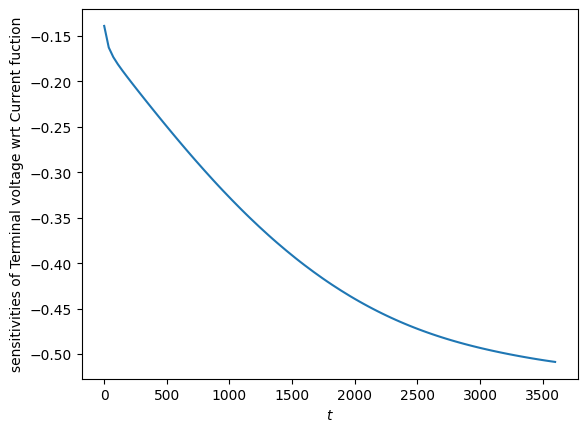

In [7]:
solution = solver.solve(
    model, t_eval,
    inputs={"Current function [A]": 0.15652},
    calculate_sensitivities=True
)
plt.plot(
    t_eval,
    solution["Terminal voltage [V]"]
    .sensitivities["Current function [A]"]
)
plt.xlabel(r'$t$')
plt.ylabel('sensitivities of Terminal voltage wrt Current fuction')
plt.show()

## Sensitivities and data fitting

Sensitivities are often used to aid data fitting by providing a means to calculate the gradient of the function to be minimised. Take for example the data fitting exercise we introduced in the previous notebook. Once again we will generate some fake data for fitting, like so:

In [8]:
data = solver.solve(
    model, t_eval,
    inputs={"Current function [A]": 0.2222}
)["Terminal voltage"](t_eval)

Now we will contruct a function to minimise, but here we will return both the value of the function, and its gradient with respect to the input parameter "Current function". Note that our objective function is the sum of squared different between the vector $\mathbf{f}$, the simulated "Terminal voltage", and $\mathbf{d}$, the vector of fake data, given by

$$\mathcal{O}(a) = \sum_{i=0}^{i=N} (f_i(a) - d_i)^2$$ 

where $a$ is the parameter to be optimised (in this case "Current function"), $f_i$ is each element of the vector $\mathbf{f}$, and $d_i$ is each element of $\mathbf{d}$. We wish to also find the gradient of this function wrt the parameter $a$, which is:

$$\frac{\partial \mathcal{O}}{\partial a}(a) = 2 \sum_{i=0}^{i=N} (f_i(a) - d_i) \frac{\partial f_i}{\partial a} $$ 

Using these equations, we will define a function that takes in as an argument $a$, and returns $(\mathcal{O}(a), \frac{\partial \mathcal{O}}{\partial a}(a))$

In [9]:
def sum_of_squares_jac(parameters):
    print('evaluating function and jacobian for p =', parameters[0])
    sim = solver.solve(
        model, t_eval,
        inputs={"Current function [A]": parameters[0]},
        calculate_sensitivities=True
    )
    term_voltage = sim["Terminal voltage"](t_eval)
    term_voltage_sens = sim["Terminal voltage"].sensitivities["Current function [A]"]

    f = np.sum((term_voltage - data) ** 2)
    g = 2 * np.sum((term_voltage - data) * term_voltage_sens)
    return f, g

We can then use this function along with an optimisation algorithm to recover the value of the Current function that was used to generate the data. In this case we will use the `scipy.optimize` module again. This module allows the use of a function in the form given above to perform the minimisation, using both the value of the objective function and its gradient to find the minimum value of $a$ in the least number of steps.

Once again, we will place bounds on "Current function [A]" between $(0.01, 0.6)$, and use a random starting value $x_0$ between these bounds.

In [10]:
bounds = (0.01, 0.6)
x0 = np.random.uniform(low=bounds[0], high=bounds[1])

print('starting parameter is', x0)
res = scipy.optimize.minimize(
    sum_of_squares_jac, [x0], bounds=[bounds], jac=True
)
print('recovered parameter is', res.x[0])

starting parameter is 0.033834758688197936
evaluating function and jacobian for p = 0.033834758688197936
evaluating function and jacobian for p = 0.6
evaluating function and jacobian for p = 0.24004164397450012
evaluating function and jacobian for p = 0.23010477556698933
evaluating function and jacobian for p = 0.22178429416885095
evaluating function and jacobian for p = 0.2221923859670257
evaluating function and jacobian for p = 0.2221837068455671
evaluating function and jacobian for p = 0.2221837028279934
recovered parameter is 0.2221837028279934
